In [1]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
import re
import optuna

/home/thomasdev/anaconda3/envs/ultralytics-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  

import torch
torch.cuda.empty_cache()

In [3]:
from modules import (
    get_data_from_trajectory_id,
    create_simple_dataloader,
    Step_1,
    Step_2,
    CombinedHamiltonianLayer,
    SimpleStackedHamiltonianNetwork,
    ReverseStep2,
    ReverseStep1,
    ReverseCombinedHamiltonianLayer,
    InverseStackedHamiltonianNetwork,
    prediction_loss,
    prediction_loss_euclidean,
    load_checkpoint,
    count_parameters,

    )

In [4]:
from modules import (    
    calculate_phi_A,
    add_phi_A_columns,
    plot_differencies,
    plot_prediction_vs_ground_truth,
    plot_distance_over_time,
    ensemble_autoregressive_prediction_mahalanobis,
    ensemble_autoregressive_prediction_gaussian_mixture,
    ensemble_autoregressive_prediction_gaussian_mixture_simple,
    test_model_in_single_trajectory,
    analyze_means_with_constants,
    visualize_trajectory_movements_with_std_ellipses,
    visualize_epoch_metrics,
    analyze_folders_means,
    analyze_mapping_net,
    test_model_in_all_trajectories_in_df,
    test_model_variance_in_all_trajectories_in_df,
    plot_prediction_losses,
    plot_variance_losses,
    test_model_with_varying_observed_points,
    test_model_variance_with_varying_observed_points,
    compute_jacobian_functional,
    compute_symplectic_product,
    check_canonical_transformation,
    test_canonical_tranformation_on_trajectory,
    test_model_in_all_trajectories_with_different_single_observation_in_df,
    plot_all_transformed_trajectories, 
    plot_transformed_trajectory,
    test_model_energy_in_single_trajectory,
    plot_transformed_trajectory_real_pendulum,
    evaluate_all_checkpoints
    )

In [5]:
with open("all_dataframes_real_pendulum_retry.pkl", "rb") as f:
    loaded_dfs = pickle.load(f)

# Access them like before:
train_df = loaded_dfs['train_df_real_pendulum_retry']
val_df = loaded_dfs['test_df_real_pendulum_retry']

train_id_df = loaded_dfs['train_id_df_real_pendulum_retry']
val_id_df = loaded_dfs['test_id_df_real_pendulum_retry']

In [6]:
save_dir_path = "./save_directory_noisy_full_pred_real_pendulum_1"


In [7]:
with open("all_dataframes_real_pendulum.pkl", "rb") as f:
    loaded_dfs = pickle.load(f)

# Access them like before:
train_df_real_pendulum = loaded_dfs['train_df_real_pendulum']
test_df_real_pendulum = loaded_dfs['test_df_real_pendulum']

train_id_df_real_pendulum = loaded_dfs['train_id_df_real_pendulum']
test_id_df_real_pendulum = loaded_dfs['test_id_df_real_pendulum']


📊 Metric summaries:
  Lowest loss of metric 'train_prediction_loss_' recorded in epoch 1677 with the value: 0.0310, the losses of the last 5 epochs are: ['0.0441', '0.0456', '0.0402', '0.0459', '0.0539']
  Lowest loss of metric 'val_prediction_loss_' recorded in epoch 1696 with the value: 0.0423, the losses of the last 5 epochs are: ['0.0920', '0.1083', '0.0830', '0.0804', '0.0423']
  Lowest loss of metric 'mean_grad_norm_' recorded in epoch 2 with the value: 0.1122, the losses of the last 5 epochs are: ['9.1738', '8.9832', '7.8312', '9.0573', '10.3185']
  Lowest loss of metric 'learning_rates' recorded in epoch 763 with the value: 0.0000, the losses of the last 5 epochs are: ['0.0005', '0.0005', '0.0005', '0.0005', '0.0005']


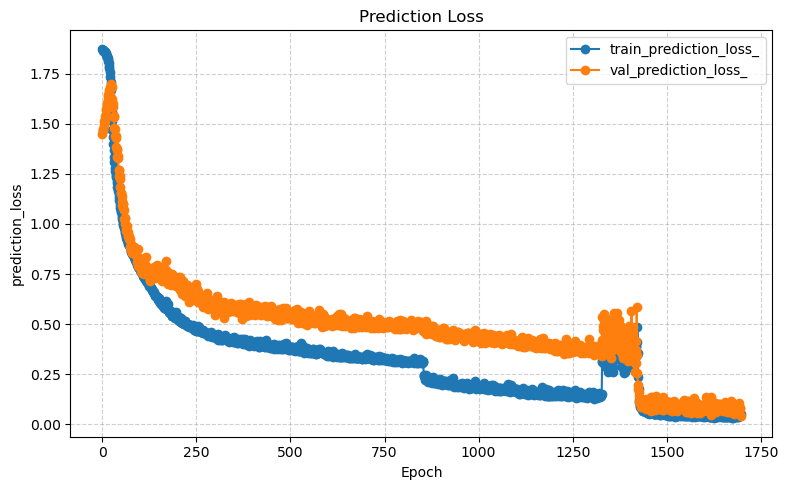

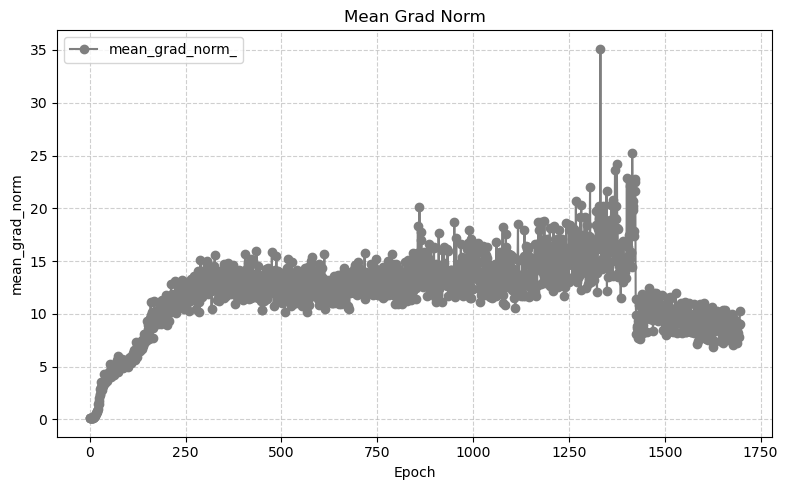

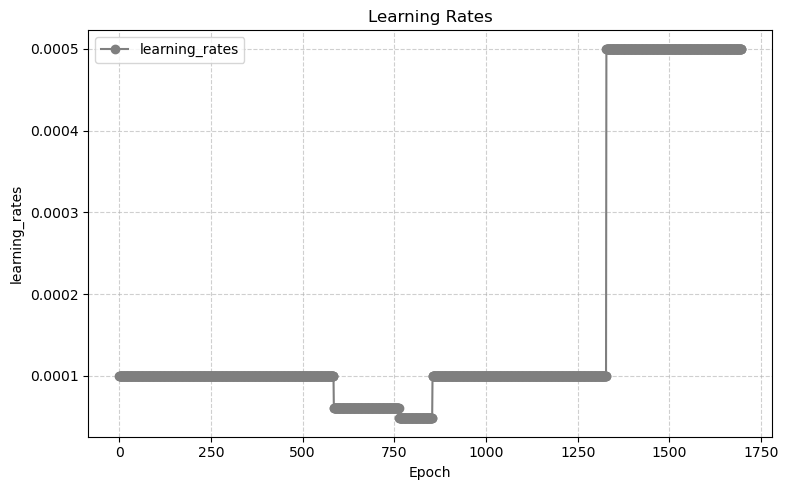

In [11]:
visualize_epoch_metrics(
 save_dir_path,
["train_prediction_loss_", "val_prediction_loss_",  "mean_grad_norm_", "learning_rates"],
plot_on_same_graph=True,
verbose=True,
specific_epochs=None
)

In [8]:
point_indexes_observed = [0]

In [9]:
dt = train_df_real_pendulum['t'][1]-train_df_real_pendulum['t'][0]
max_t_training = 6.0
trajectory_id=1

In [10]:
device = "cuda"
mapping_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
    n_layers=10,
        # MLP Architecture parameters
    hidden_dims= [33, 60, 32],
    n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
        
        # Activation parameters
    activation = 'gelu',
    activation_params = None,
    final_activation = None,   #Final layer activation function
    #final_activation_only_on_final_layer = True,
    tanh_wrapper = False,
        
        # Initialization parameters
    weight_init = 'orthogonal',
    weight_init_params = {'gain': 1},
    bias_init = 'zeros',
    bias_init_value = 0.0,
        
        
        # Architectural choices
    use_bias = True,
    use_layer_norm = False,
    
    # Input/Output parameters
    input_dim = 2,  # x or u and t
    output_dim = 1,  # scalar G or F
    a_eps_min= 0.5,  # Minimum value for a
    a_eps_max= 2,  # Maximum value for a  
    a_k= 0.1,

    step_1_a_mean_innit= 1.2,
    step_2_a_mean_innit= 1.2,
    std_to_mean_ratio_a_mean_init= 0.0,

    step_1_gamma_mean_innit= 0.5,
    step_2_gamma_mean_innit= 0.5,
    std_to_mean_ratio_gamma_mean_init= 0.0,

    step_1_c1_mean_innit= 0.0,
    step_2_c1_mean_innit= 0.0,
    std_to_mean_ratio_c1_mean_init= 1.0,

    step_1_c2_mean_innit= 0.0,
    step_2_c2_mean_innit= 0.0,
    std_to_mean_ratio_c2_mean_init= 1.0,

    bound_innit=0.0,
).to(device)

In [11]:


checkpoint_path = os.path.join(save_dir_path, "best_model.pt")

load_checkpoint(path=checkpoint_path, mapping_net=mapping_net, device=device, optimizer=None, scheduler=None)

inverse_net = InverseStackedHamiltonianNetwork(forward_network=mapping_net)


Successfully loaded model
Created inverse network with 10 reverse layers


/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:7003: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=devic

In [20]:
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ---------------------------------------------------------
# 1. PREPARE FIXED ARGUMENTS
# ---------------------------------------------------------
# These arguments never change during the optimization.
# We pack them here to keep the objective function clean.
fixed_args = {
    "get_data_from_trajectory_id_function": get_data_from_trajectory_id,
    "loss_type": "mse",
    "test_id_df": test_id_df_real_pendulum,
    "test_df": test_df_real_pendulum,
    "trajectory_id": trajectory_id,
    "mapping_net": mapping_net,
    "inverse_net": inverse_net,
    "device": device,
    "point_indexes_observed": point_indexes_observed,
    "show_zeroings": False, 
    "show_period": False,
    "period": 0.0,
    "connect_points": False,
    "portion_to_visualize": [0,32],
    "max_t_training": max_t_training,
    "efficiently": False,
    "method": "gaussian_mixture_simple",
    "threshold": 1.0,
    "dt": dt,
    "alpha":1.0,
    "gamma":1.0,
    "cluster_weight_threshold": 0.4,
    "search_range_lower_pct": 0.1,  # Assuming this is fixed
    "verbose":False,
    "plot":False,
}

# ---------------------------------------------------------
# 2. DEFINE THE OBJECTIVE FUNCTION
# ---------------------------------------------------------
def objective(trial):
    """
    This function runs ONE experiment. 
    Optuna provides the 'trial' object which we use to select params.
    """
    

    # B. Conditional Logic (The Bayesian part)
    # Optuna's sampler will learn that 'threshold' is only relevant when efficiently=False

        
    # suggest_float(name, low, high)

    search_range_upper_pct_param = trial.suggest_float("search_range_upper_pct", 0.2, 0.8) 
    max_n_components_param = trial.suggest_int("max_n_components", 2, 10)

    # C. Run your actual function
    # We handle exceptions so one bad run doesn't crash the whole study
    try:
        mean_loss = test_model_in_single_trajectory(
            search_range_upper_pct = search_range_upper_pct_param,
            max_n_components = max_n_components_param,
            **fixed_args
        )
    except Exception as e:
        print(f"Trial failed: {e}")
        # Return infinity so Optuna knows this was a terrible run
        return float('inf')

    # D. Return the value we want to MINIMIZE
    return mean_loss

# ---------------------------------------------------------
# 3. RUN THE OPTIMIZATION (THE STUDY)
# ---------------------------------------------------------
print("Starting Bayesian Optimization...")

# Create the study. We want to 'minimize' the loss.
study = optuna.create_study(direction="minimize")

# n_trials=20 means it will run your function 20 times. 
# Increase this to 50 or 100 if you have time.
study.optimize(objective, n_trials=30, show_progress_bar=True)

# ---------------------------------------------------------
# 4. VIEW RESULTS
# ---------------------------------------------------------
print("-" * 30)
print("BEST RESULTS FOUND:")
print(f"Best Mean Loss: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

# If you want to see all trials as a DataFrame:
df_results = study.trials_dataframe()
# print(df_results)

Starting Bayesian Optimization...


Best trial: 23. Best value: 0.0238884: 100%|██████████| 30/30 [33:50<00:00, 67.69s/it]

------------------------------
BEST RESULTS FOUND:
Best Mean Loss: 0.023888427764177322
Best Hyperparameters: {'search_range_upper_pct': 0.25664916791431247, 'max_n_components': 5}



=== Efficient Method - Forward Pass Count ===
mapping_net calls: 13
inverse_net calls: 13
Total forward passes: 26
Observed time points: [0.]


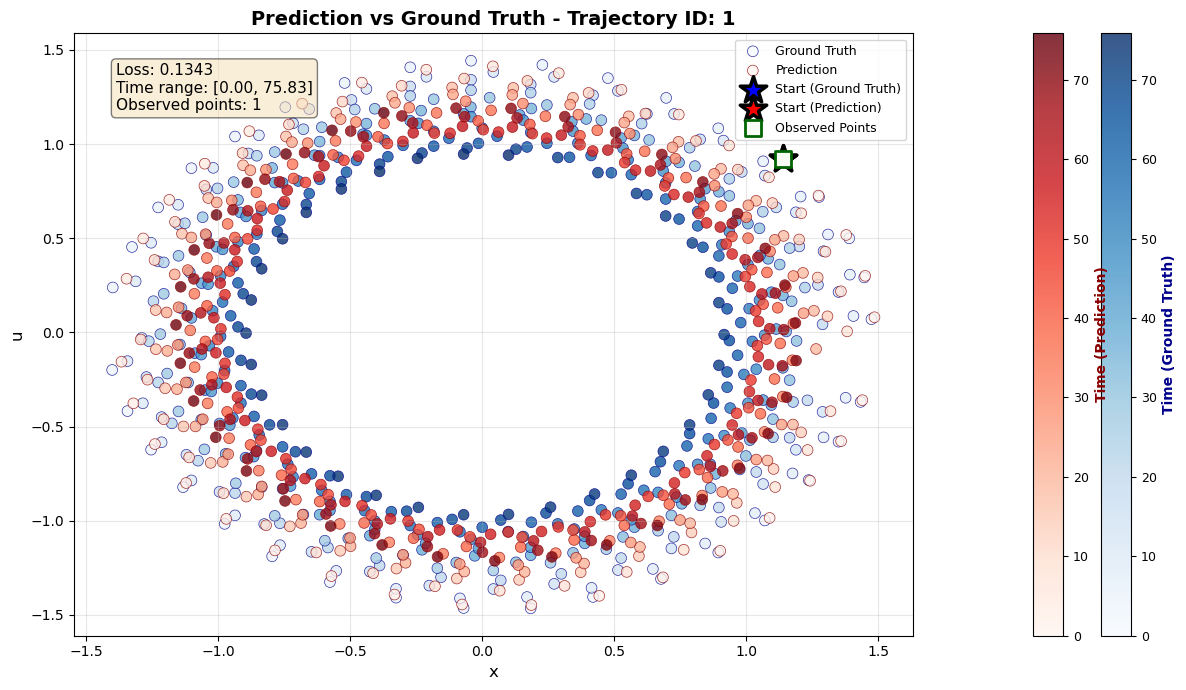

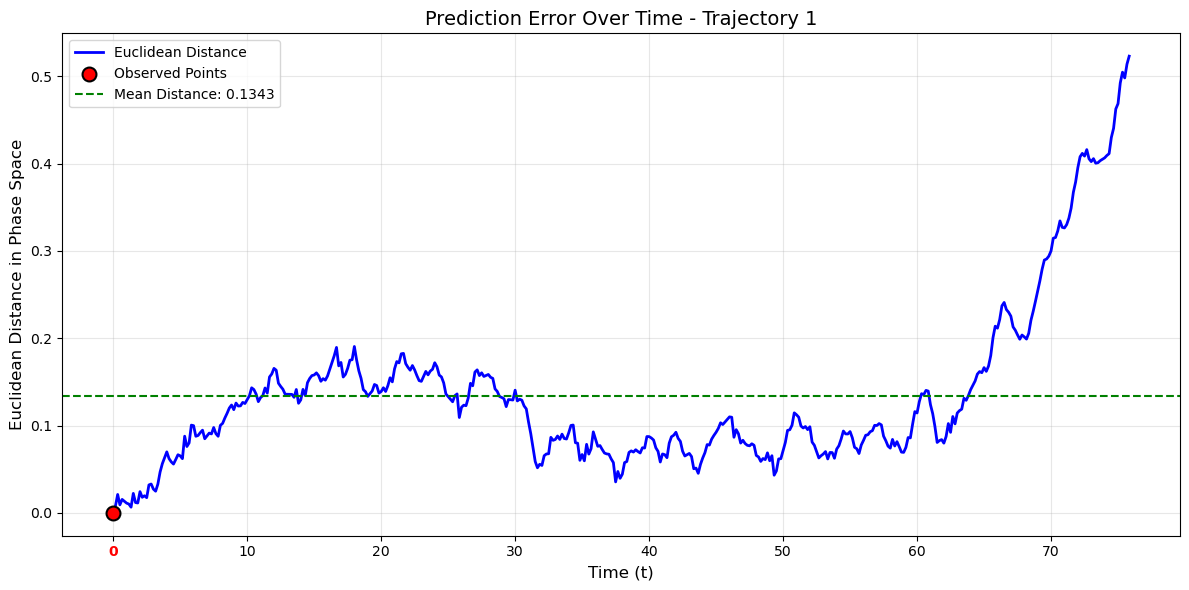

In [ ]:
test_model_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
loss_type="mse", 
test_id_df=train_id_df_real_pendulum, 
test_df=train_df_real_pendulum, 
trajectory_id=trajectory_id, mapTrueping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
connect_points=False, 
portion_to_visualize=None, 
show_zeroings=False, 
show_period=False, 
period=0.0, 
max_t_training=max_t_training, 
efficiently=True, 
method = "gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.3, 
max_n_components=5, 
search_range_lower_pct=0.005, 
search_range_upper_pct=0.03, 
verbose=True)


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 4
Total forward passes: 8
Observed time points: [0.]


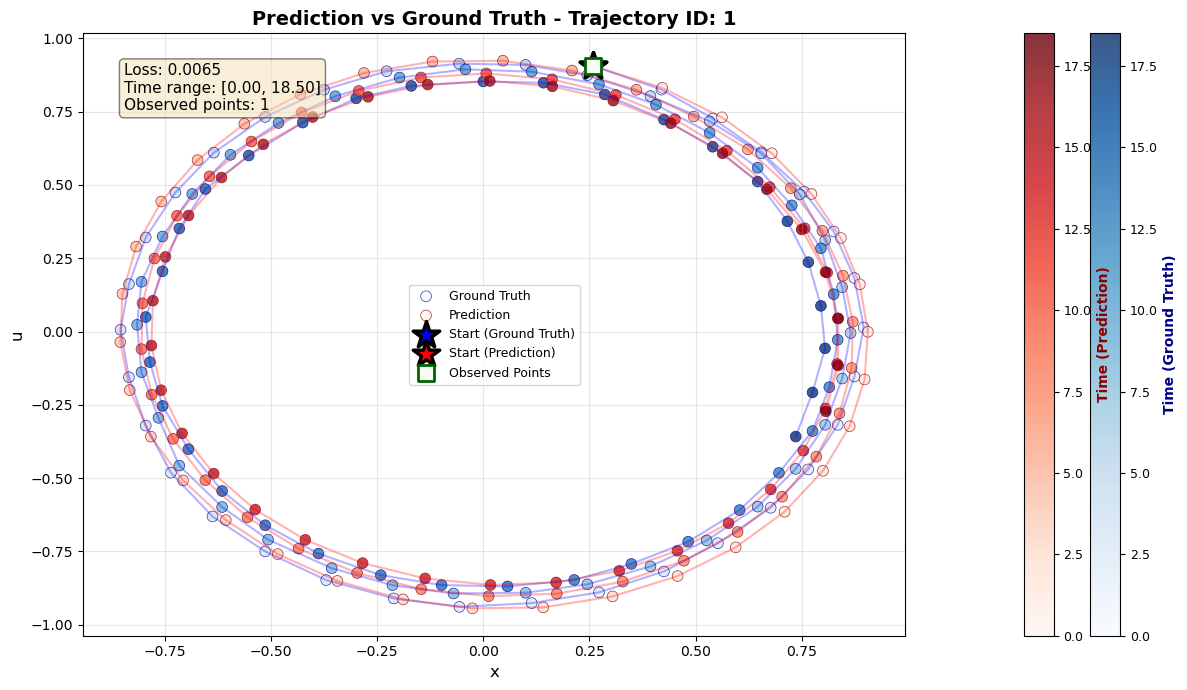

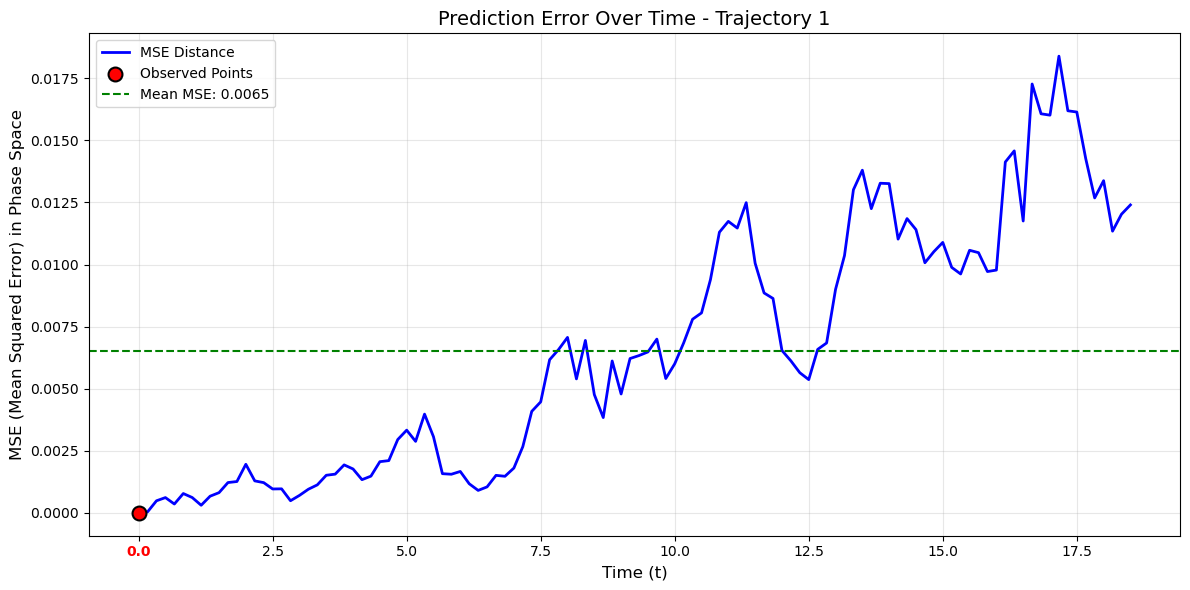

In [ ]:
test_model_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
loss_type="mse", 
test_id_df=test_id_df_real_pendulum, 
test_df=test_df_real_pendulum, 
trajectory_id=1, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
connect_points=True, 
portion_to_visualize=None, 
show_zeroings=False, 
show_period=False, 
period=0.0, 
max_t_training=max_t_training, 
efficiently=True,  
method = "gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.5, 
max_n_components=4, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.6, 
verbose=True)

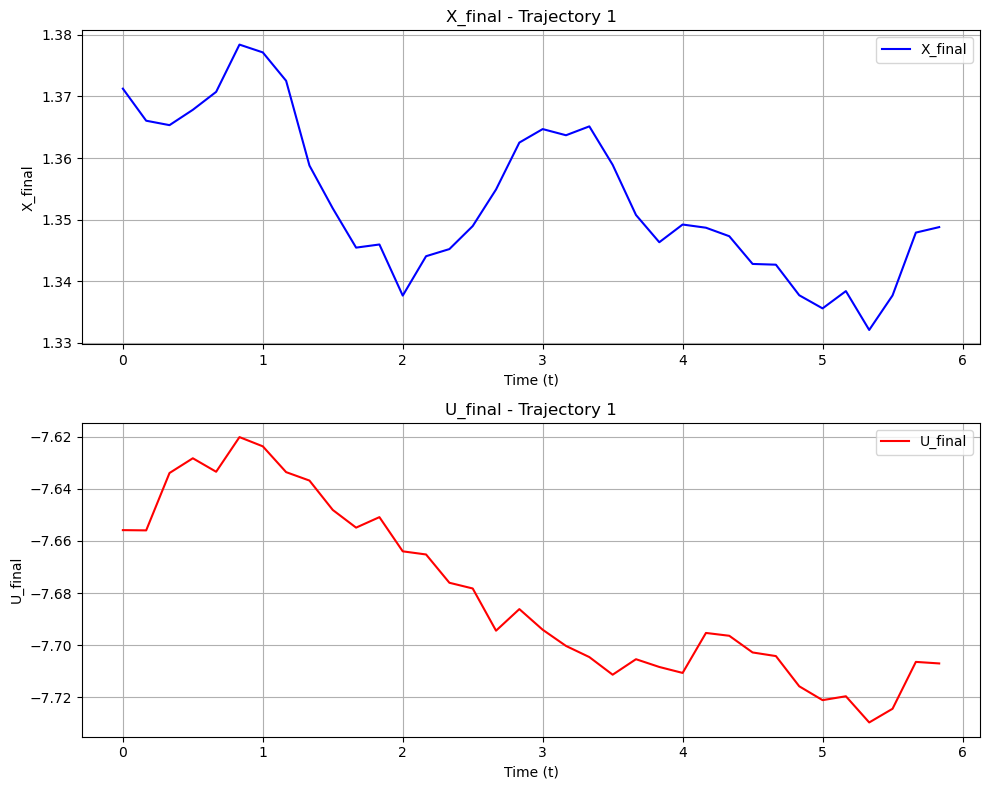

In [12]:


plot_transformed_trajectory_real_pendulum(
    test_id_df=test_id_df_real_pendulum.drop(['energy'], axis=1),
    test_df=test_df_real_pendulum,
    trajectory_id=1,
    get_data_from_trajectory_id_function=get_data_from_trajectory_id,
    mapping_net=mapping_net,
    max_t_training=max_t_training,
    device=device,
)


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 4
Total forward passes: 8


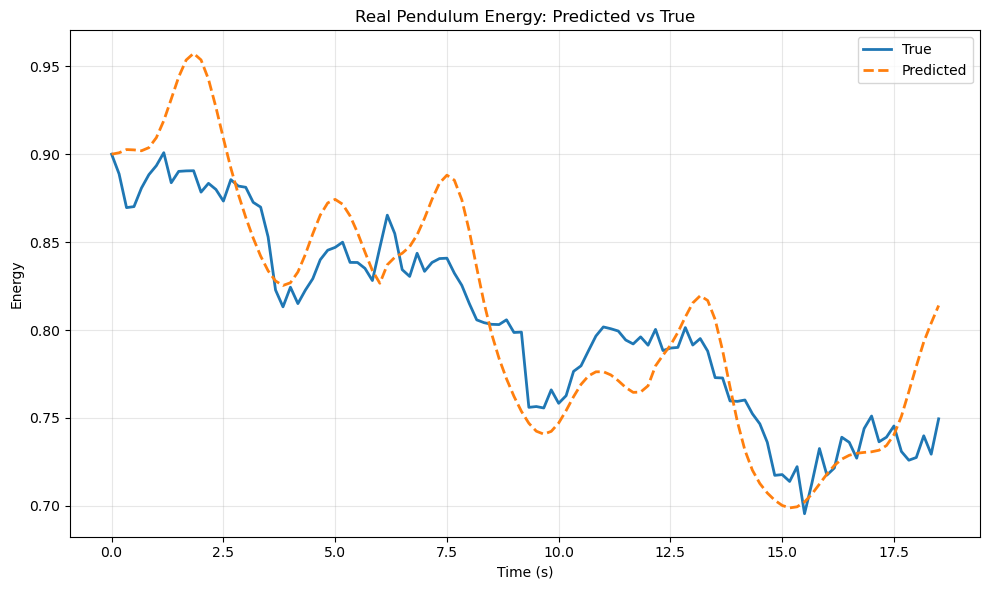

In [11]:
test_model_energy_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=test_id_df_real_pendulum, test_df=test_df_real_pendulum, trajectory_id=1, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6,case="real_pendulum",length=1.0, k=1, mass=1, g=3.0, constant=2.4, verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 14
inverse_net calls: 897
Total forward passes: 911
Coverage: 100.0%
Observed time points: [0.]


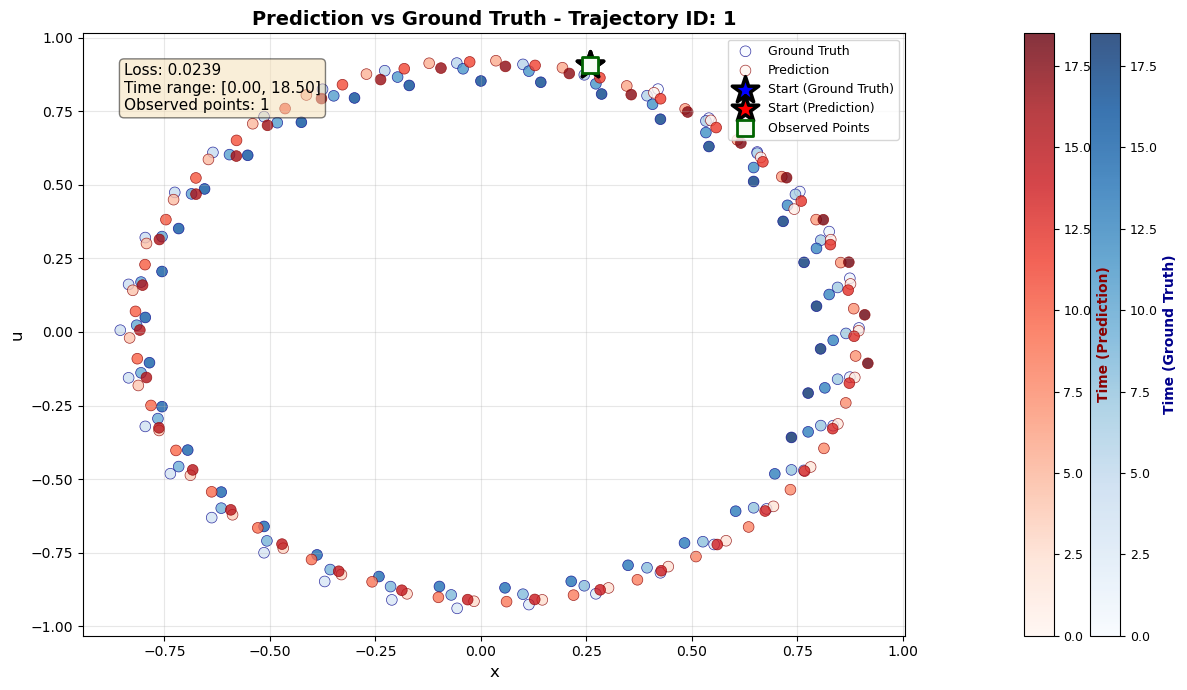

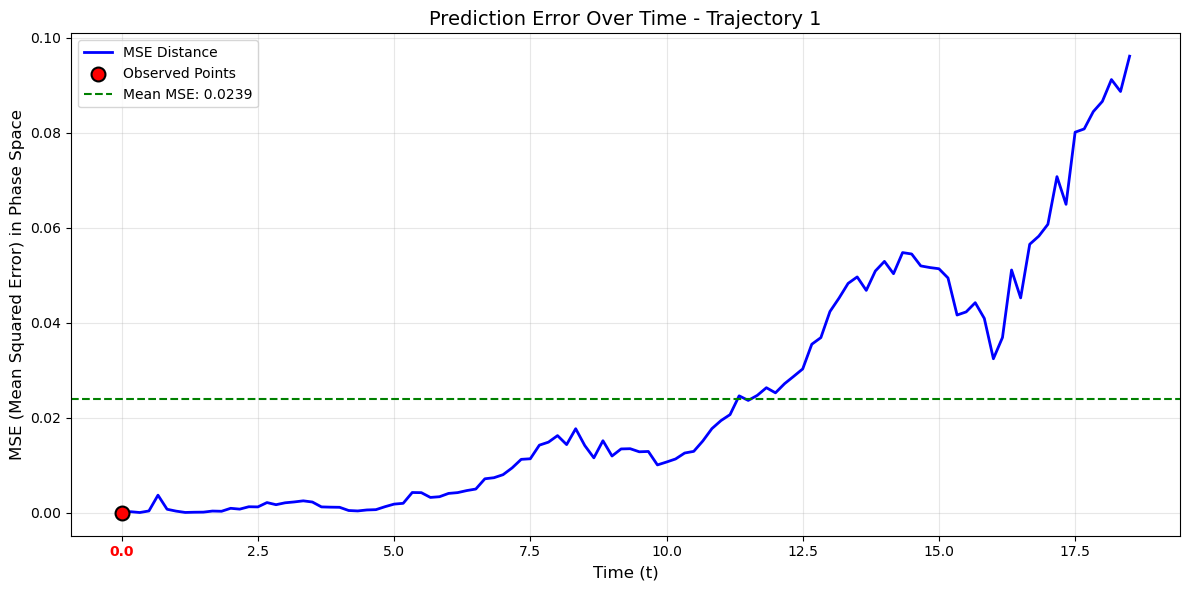

In [21]:
test_model_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
loss_type="mse", 
test_id_df=test_id_df_real_pendulum, 
test_df=test_df_real_pendulum, 
trajectory_id=1, mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
connect_points=False, 
portion_to_visualize=None, 
show_zeroings=False, 
show_period=False, 
period=0.0, 
max_t_training=max_t_training, 
efficiently=False,  
method = "gaussian_mixture_simple", 
threshold=1.0, dt=dt, 
alpha=1.0,
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=5, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.25664916791431247, 
verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 14
inverse_net calls: 897
Total forward passes: 911
Coverage: 100.0%


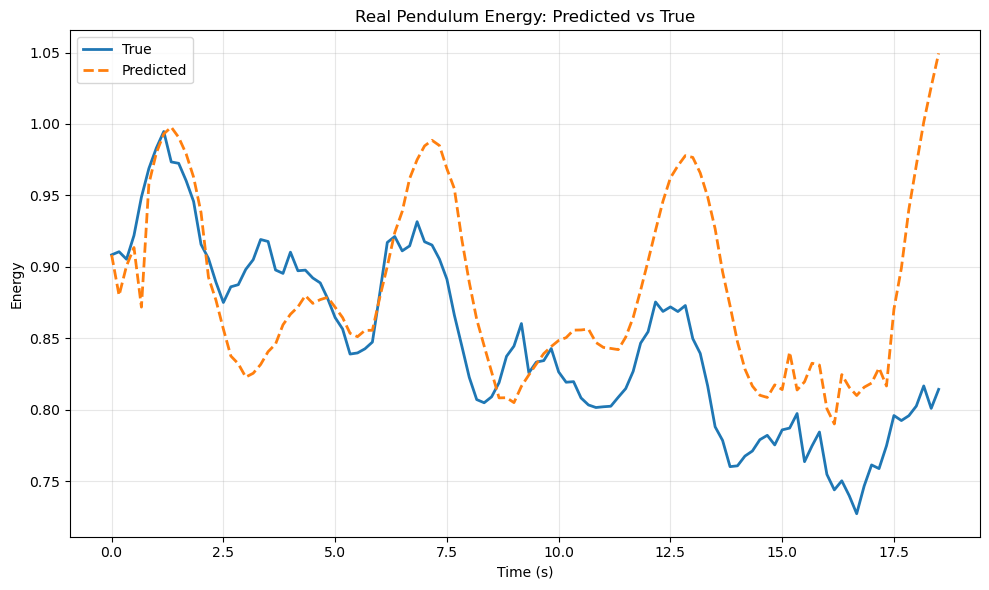

In [22]:
test_model_energy_in_single_trajectory(
get_data_from_trajectory_id_function=get_data_from_trajectory_id, 
test_id_df=test_id_df_real_pendulum, 
test_df=test_df_real_pendulum, 
trajectory_id=1, 
mapping_net=mapping_net, 
inverse_net=inverse_net, 
device=device, 
point_indexes_observed=point_indexes_observed, 
max_t_training=max_t_training, 
efficiently=False,  
method = "gaussian_mixture_simple", 
threshold=1.0, 
dt=dt, 
alpha=1.0, 
gamma=1.0, 
cluster_weight_threshold=0.4, 
max_n_components=5, 
search_range_lower_pct=0.1, 
search_range_upper_pct=0.25664916791431247, 
case="real_pendulum",
length=1.0, k=1, mass=1, g=3.0, constant=2.65, 
verbose=True)